In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
sns.set(rc={'figure.figsize':(24, 12)})

In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, \
classification_report

## Загрузка датасета и исследование данных

In [3]:
df = pd.read_csv('train_dataset_train1.csv')
test = pd.read_csv('test_dataset_test1.csv')

In [4]:
dd = pd.concat([df,test],axis=0)

In [748]:
cols = ['Место', 'Улица', 'Дорога', 'Километр', 'Вид ДТП', 'month', 'hour', 'weekday',  'day', 'cluster']
target = ['Погибло', 'Погибло детей', 'Ранено', 'Ранено детей']

In [6]:
dd['Вид ДТП'].fillna('Иной вид ДТП', inplace=True)
dd = dd.reset_index(drop=True)

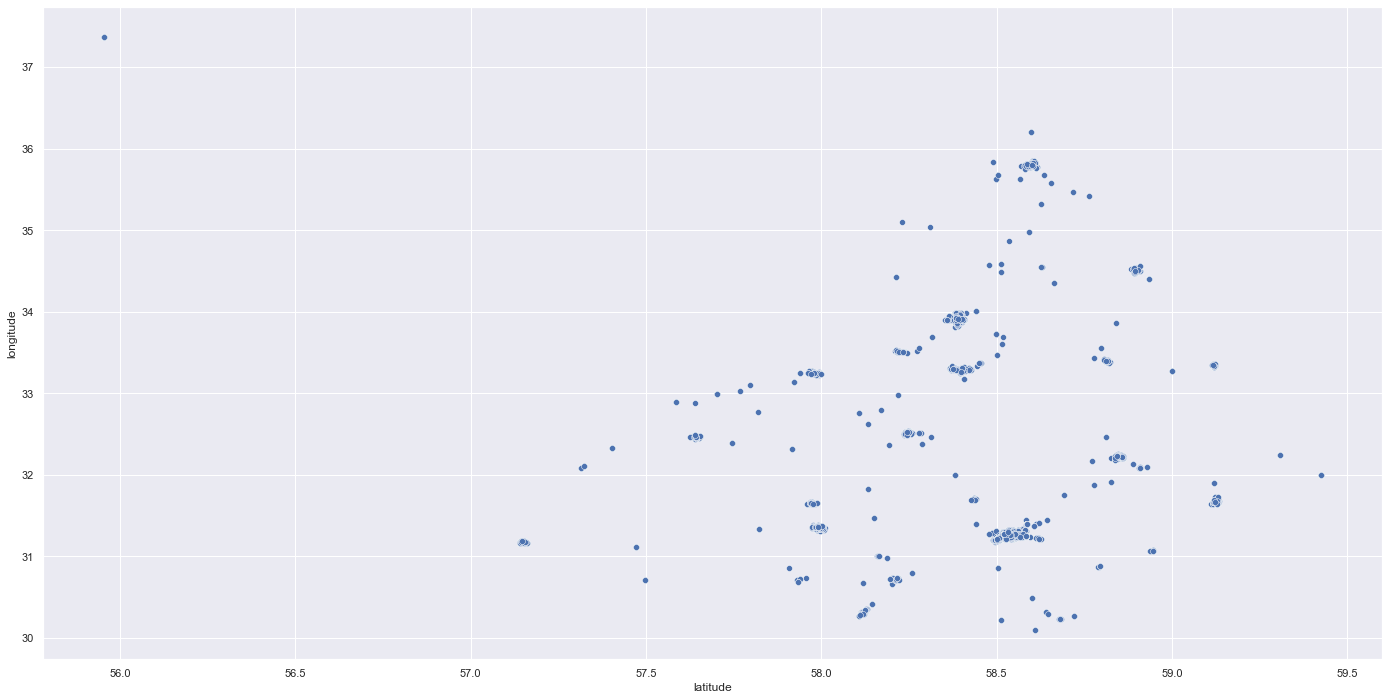

In [230]:
# Построим график по геоточкам и проанализируем его
ds = pd.read_excel('DTP.xlsx')
ts = pd.read_excel('DTP_t.xlsx')
sns.scatterplot(data=ds, x='latitude', y='longitude')
plt.savefig("Accident")

In [232]:
dts = pd.concat([ds,ts],axis=0)

На графике фидно, что ДТП формируют кластеры. Тогда оценим их для каждой целевой переменной

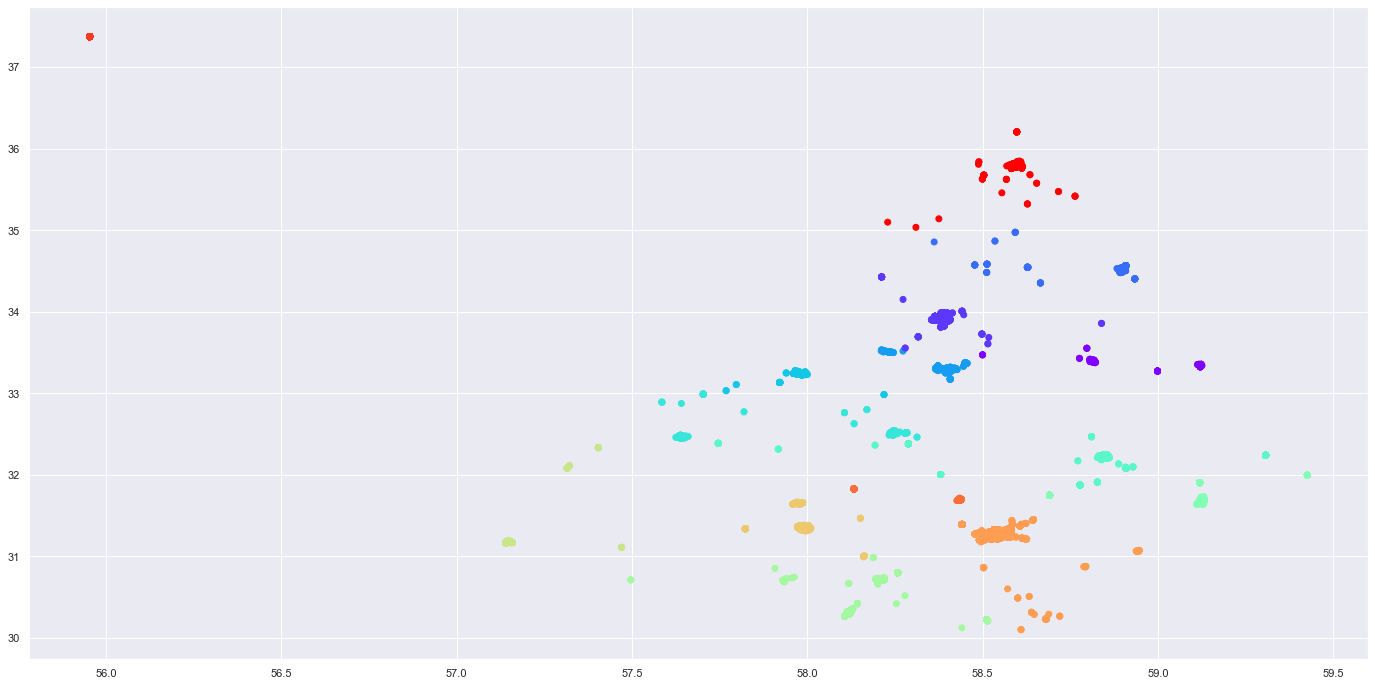

In [561]:
from sklearn.cluster import BisectingKMeans

# Получение массива точек
X1 = np.array(dts['latitude'])
X2 = np.array(dts['longitude'])
X3 = np.vstack((X1,X2)).T

# Кластеризация
bisect_means = BisectingKMeans(n_clusters=15, random_state=0).fit(X3)
cluster = bisect_means.labels_

# Построение графика
plt.scatter(X3[:,0],X3[:,1], c=bisect_means.labels_, cmap='rainbow')
plt.savefig('Clusters')

In [562]:
dd['cluster'] = cluster

In [9]:
from collections import Counter

counter_in = Counter(ds['Ранено'])
counter_in_kids = Counter(ds['Ранено детей'])
counter_die = Counter(ds['Погибло'])
counter_die_kids = Counter(ds['Погибло детей'])

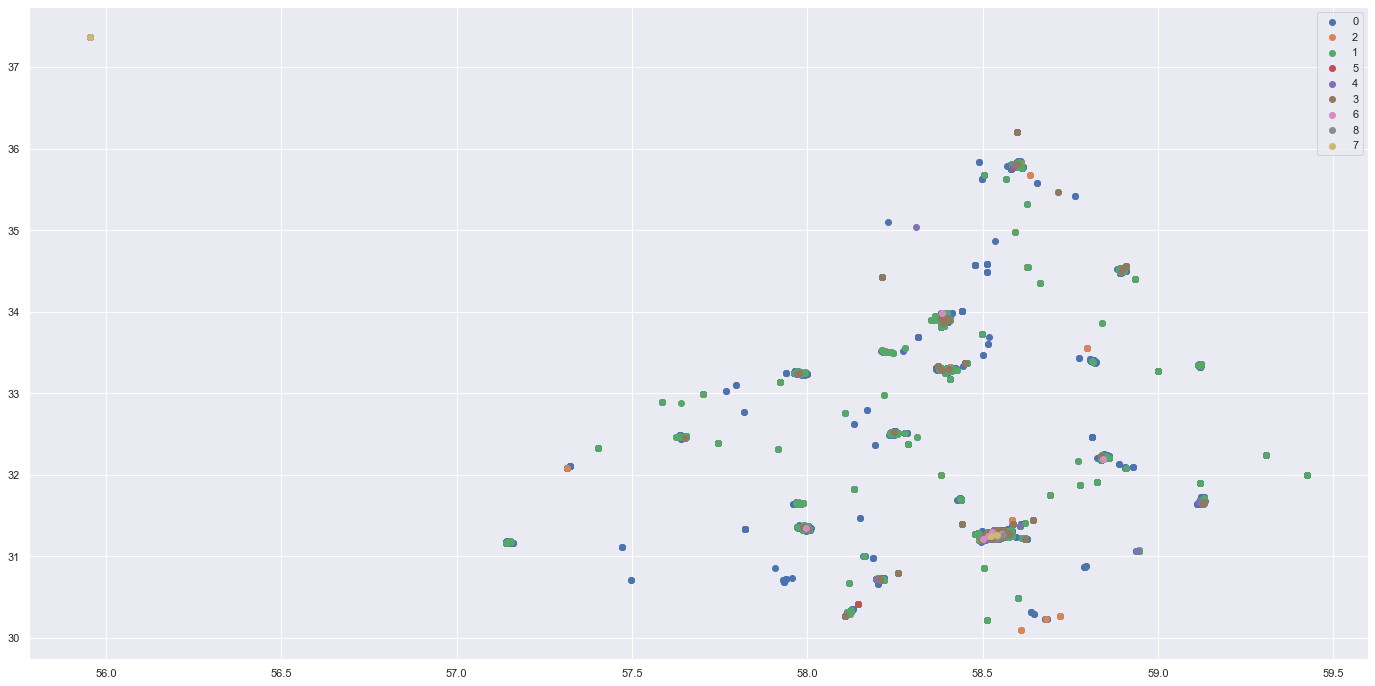

In [224]:
# График распределения количества раненых по кластерам
for label, _ in counter_in.items():
    row_ix = np.where(ds['Ранено'] == label)[0]
    plt.scatter(X3[row_ix, 0], X3[row_ix, 1], label=str(label))
plt.legend()
plt.savefig('Clusters_injured')
plt.show()

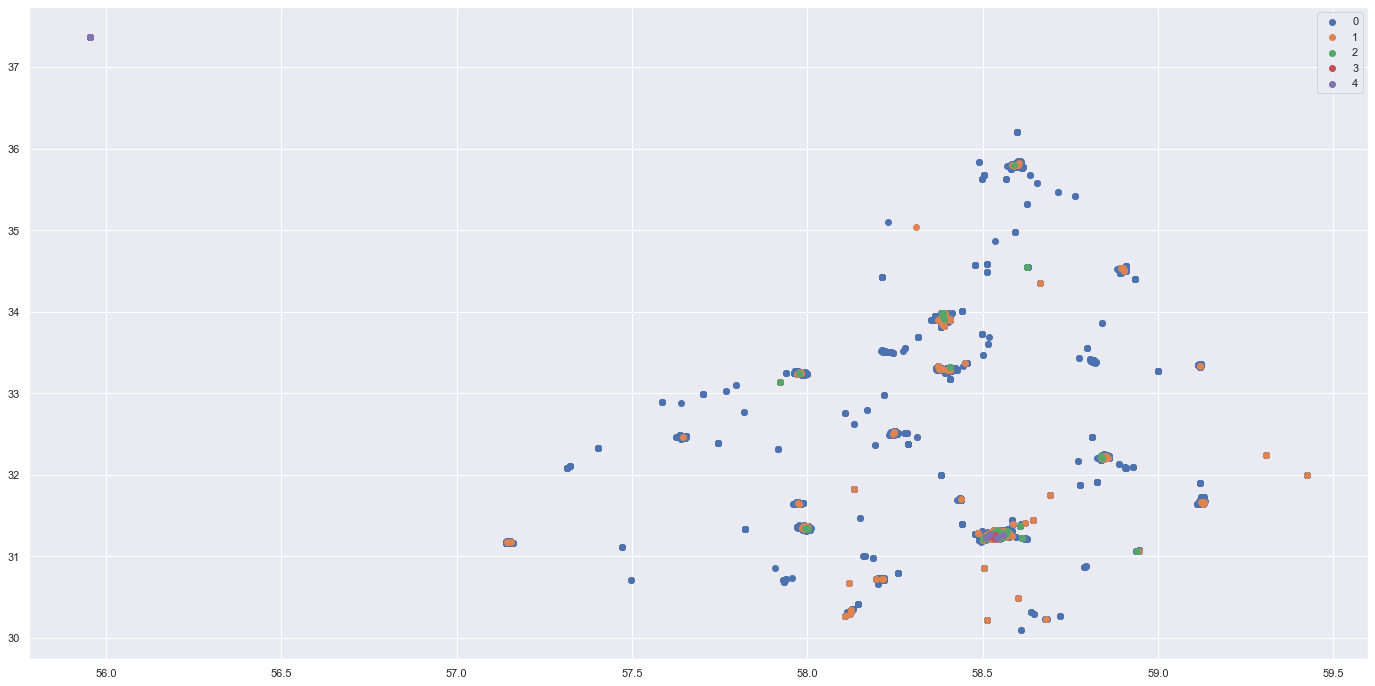

In [227]:
# График распределения количества раненых детей по кластерам
for label, _ in counter_in_kids.items():
    row_ix = np.where(ds['Ранено детей'] == label)[0]
    plt.scatter(X3[row_ix, 0], X3[row_ix, 1], label=str(label))
plt.legend()
plt.savefig('Clusters_injured_kids')
plt.show()

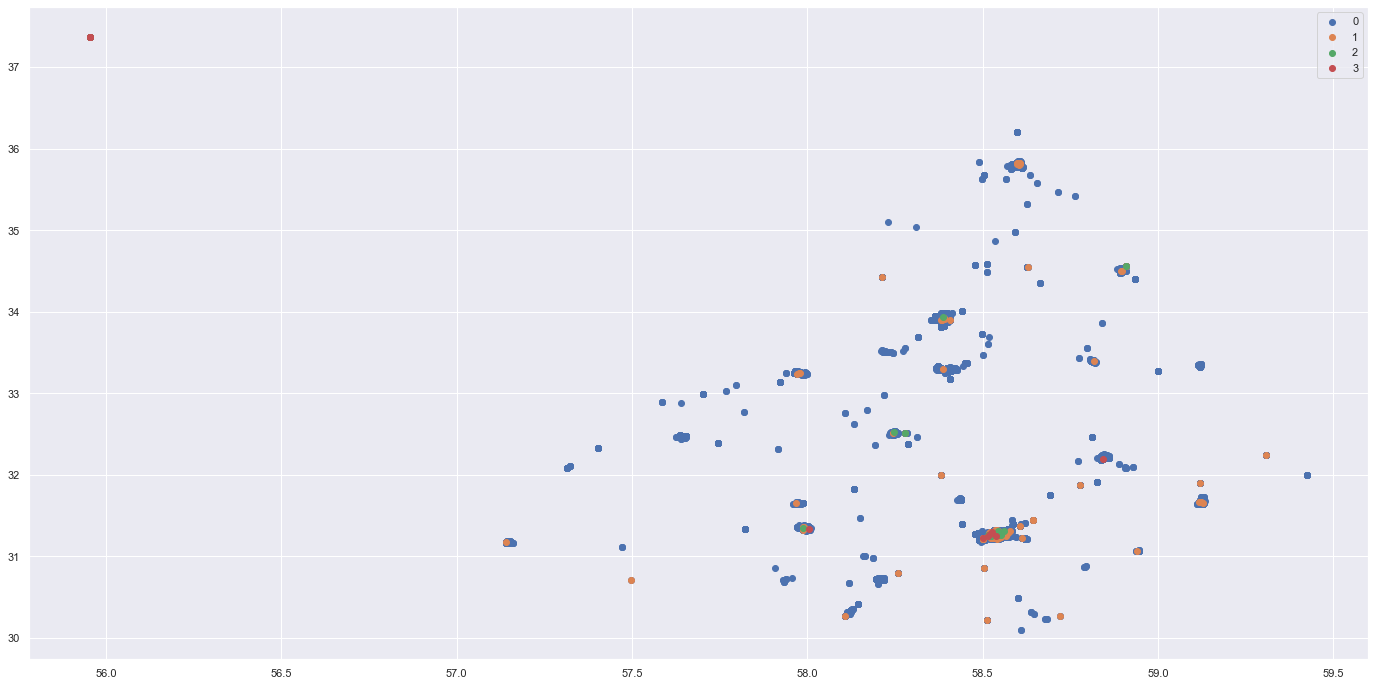

In [228]:
# График распределения количества погибших по кластерам
for label, _ in counter_die.items():
    row_ix = np.where(ds['Погибло'] == label)[0]
    plt.scatter(X3[row_ix, 0], X3[row_ix, 1], label=str(label))
plt.legend()
plt.savefig('Clusters_die')
plt.show()

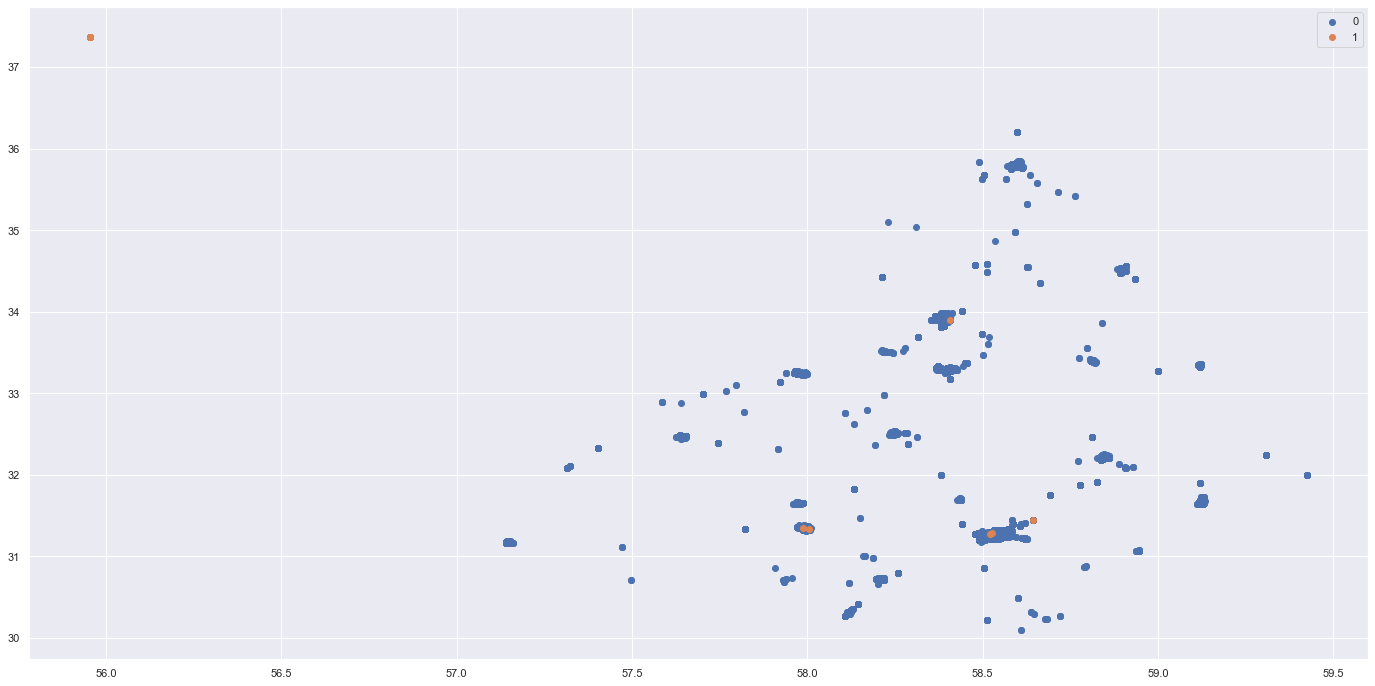

In [229]:
# График распределения количества погибших детей по кластерам
for label, _ in counter_die_kids.items():
    row_ix = np.where(ds['Погибло детей'] == label)[0]
    plt.scatter(X3[row_ix, 0], X3[row_ix, 1], label=str(label))
plt.legend()
plt.savefig('Clusters_die_kids')
plt.show()

In [ ]:
# Диаграмма количества раненых детей помесячено
sns.histplot(data = ds.loc[ds['Ранено детей'] != 0], x='month')
plt.savefig('Injured_kids_per_months')

In [ ]:
# Диаграмма количества погибших детей помесячено
sns.histplot(data = ds.loc[ds['Погибло детей'] != 0], x='month')
plt.savefig('Die_kids_per_months')

Пики погибших и раненых детей приходтся на периоды проведения школьных каникул

In [ ]:
# Диаграмма количества погибших помесячено
sns.histplot(data = ds.loc[ds['Погибло'] != 0], x='month')
plt.savefig('Die_per_months')

In [ ]:
# Диаграмма количества раненых помесячено
sns.histplot(data = ds.loc[ds['Ранено'] != 0], x='month')
plt.savefig('Injured_per_months')

Большое число погибших среди всех пострадавших приходится на зимний и осенний период, может очень хорошо коррелироваться с погодными условиями. По раненым пострадавшим пики приходятся на летний период

## Получение месяца, дня недели и часа ДТП

In [11]:
import datetime as dt
dateparser = lambda x: dt.datetime.strptime(x, "%d.%m.%Y")
timeparser = lambda x: dt.datetime.strptime(x, "%H:%M:%S")

In [12]:
dd['date'] = dd['Дата'].apply(dateparser)
dd['month'] = dd['date'].dt.month
dd['day']  = dd['date'].dt.day
dd['time'] = dd['Время'].apply(timeparser)
dd['hour'] = dd['time'].dt.hour
dd['minutes'] = dd['time'].dt.minute

In [13]:
# Получение дня недели
dd['weekday'] = None
dd['nameday'] = None

for i in list(dd.index):
    dd['weekday'][i] = dd['date'][i].dayofweek
    dd['nameday'][i] = dd['date'][i].strftime("%A")   

C:\Users\DERIAB~1\AppData\Local\Temp/ipykernel_6752/1073706632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['weekday'][i] = dd['date'][i].dayofweek
C:\Users\DERIAB~1\AppData\Local\Temp/ipykernel_6752/1073706632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['nameday'][i] = dd['date'][i].strftime("%A")


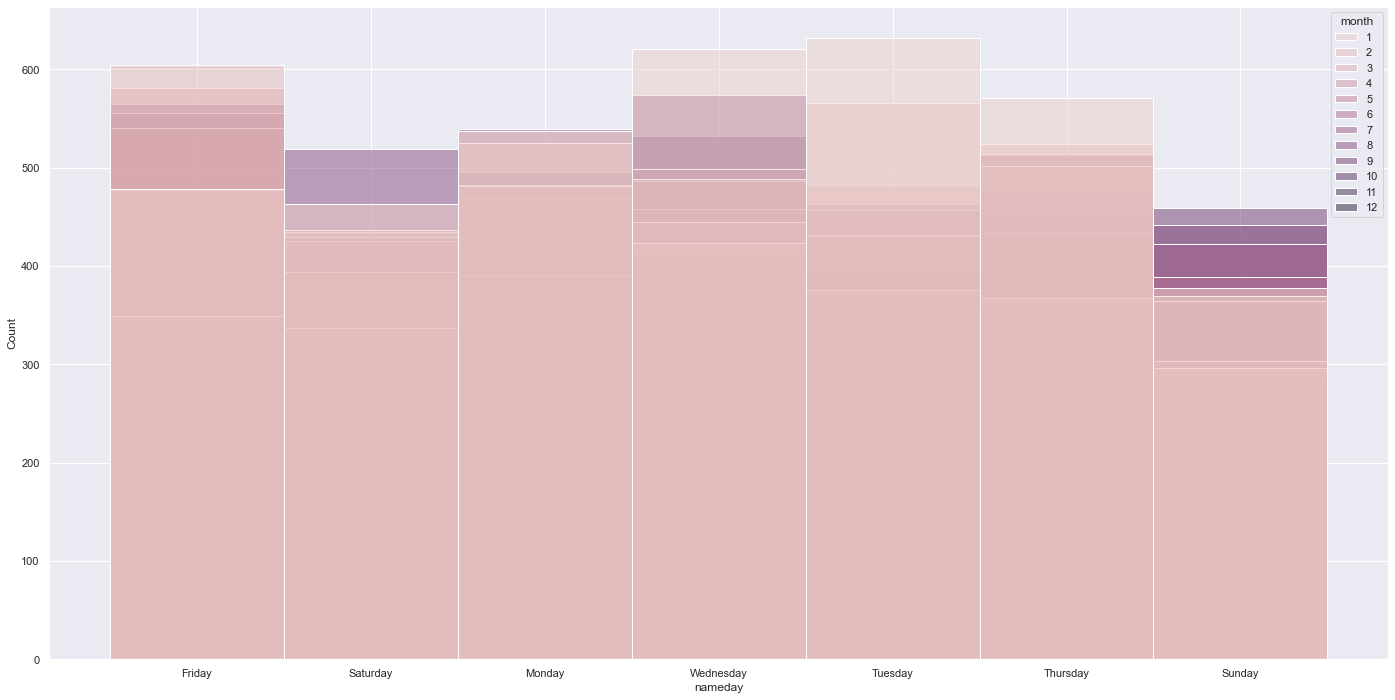

In [62]:
# Частота ДТП по дням недели
sns.histplot(data=df, x='nameday', hue='month')
plt.savefig('hist_acc_dayweek')

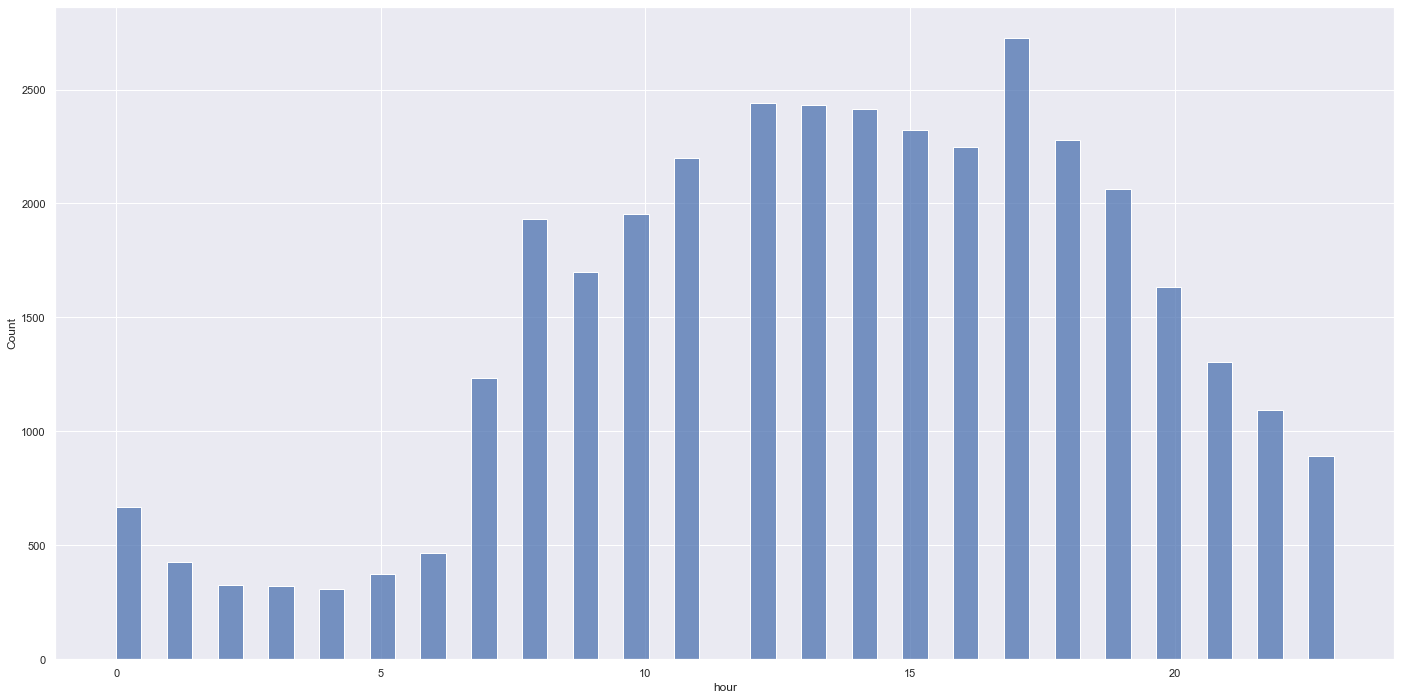

In [61]:
# Частота ДТП по времени суток
sns.histplot(data=df, x='hour')
plt.savefig('hist_acc_hour')

## Кодирование категориальных признаков

In [15]:
dd['Место'] = pd.Categorical(dd['Место'])
dd['Место'].astype('category').cat.codes
dd['Место'] = dd['Место'].cat.codes

dd['Улица'] = pd.Categorical(dd['Улица'])
dd['Улица'].astype('category').cat.codes
dd['Улица'] = dd['Улица'].cat.codes

dd['Дорога'] = pd.Categorical(dd['Дорога'])
dd['Дорога'].astype('category').cat.codes
dd['Дорога'] = dd['Дорога'].cat.codes

dd['Вид ДТП'] = pd.Categorical(dd['Вид ДТП'])
dd['Вид ДТП'].astype('category').cat.codes
dd['Вид ДТП'] = dd['Вид ДТП'].cat.codes

In [931]:
dg = dd.head(35771)

In [932]:
dg.fillna(0, inplace=True)

C:\Users\deriabin_ns\Anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [855]:
testg = dd.tail(6788)

In [856]:
testg.fillna(0, inplace=True)

In [935]:
X, y = dg[cols], dg[target[0]]

## Расчет веса целевой переменной

In [936]:
from sklearn.utils.class_weight import compute_class_weight

weight = compute_class_weight(class_weight='balanced', classes=dg[target[0]].unique(), y=y)
weight = {dg[target[0]].unique()[i]:weight[i] for i in range(len(dg[target[0]].unique()))}
weight


{1.0: 0.777909122361896,
 0.0: 0.5712118218257777,
 2.0: 1.363595013477089,
 3.0: 4.33871140651801}

In [937]:
# Разбиение на обучающую выборку (70%) и тестовую выборку (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Обучение модели

In [938]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=weight, criterion='entropy', max_depth=12)

In [948]:
%%time
rfc.fit(X, y)

Wall time: 1min 35s


RandomForestClassifier(class_weight={0.0: 0.5712118218257777,
                                     1.0: 0.777909122361896,
                                     2.0: 1.363595013477089,
                                     3.0: 4.33871140651801},
                       criterion='entropy', max_depth=12, n_estimators=1000,
                       random_state=42)

In [949]:
%%time
y_pred = rfc.predict(X_test)

Wall time: 12.3 s


In [950]:
%%time
y_predict = rfc.predict(testg[cols])
sum(y_predict)

Wall time: 7.24 s


89.0

In [876]:
%%time
y_predict = rfc.predict(pd.concat([testg[cols].reset_index(drop=True),f['Ранено']],axis=1))
sum(y_predict)

Wall time: 6.26 s


418.0

In [951]:
# Оценка точности классификации
print('accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy 0.9872010278711207
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      8888
         1.0       0.98      0.99      0.98      6497
         2.0       0.98      1.00      0.99      3694
         3.0       0.99      1.00      1.00      1157

    accuracy                           0.99     20236
   macro avg       0.99      0.99      0.99     20236
weighted avg       0.99      0.99      0.99     20236



In [918]:
# model is the trained model
importances = rfc.feature_importances_

# train_features is the dataframe of training features
feature_list = list(X.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results

,feature,importance
0,hour,0.197984
1,day,0.179731
2,month,0.133030
3,weekday,0.105749
4,Улица,0.105725
5,Вид ДТП,0.067299
6,Место,0.059470
7,Километр,0.054435
8,cluster,0.051734
9,Дорога,0.044842
